In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from IPython.display import display

#%matplotlib notebook

import sys
import sklearn
#import pandas as pd
import matplotlib as mpl
#import matplotlib.pyplot as plt
import seaborn as sns

import re

%matplotlib inline

pd.options.display.max_rows = 10

### Зареждане и проверка на формата на данните:

In [4]:
multi = pd.read_csv('data/multipleChoiceResponses.csv', encoding='latin_1', low_memory=False)
free  = pd.read_csv('data/freeformResponses.csv', encoding='latin_1', low_memory=False)
print('multiple choice:', multi.shape)
print('free form:', free.shape)

multiple choice: (16716, 228)
free form: (16716, 62)


Ще започна с `multiple coice` данните, защото ми се вижда по-лесно.

### Наименования на колоните

In [5]:
multi.columns

Index(['GenderSelect', 'Country', 'Age', 'EmploymentStatus', 'StudentStatus',
       'LearningDataScience', 'CodeWriter', 'CareerSwitcher',
       'CurrentJobTitleSelect', 'TitleFit',
       ...
       'JobFactorExperienceLevel', 'JobFactorDepartment', 'JobFactorTitle',
       'JobFactorCompanyFunding', 'JobFactorImpact', 'JobFactorRemote',
       'JobFactorIndustry', 'JobFactorLeaderReputation', 'JobFactorDiversity',
       'JobFactorPublishingOpportunity'],
      dtype='object', length=228)

Всъщност имаме фаил с информация за колоните. Да не забравя, че тук може да се изпълняват bash команди.

In [6]:
!head data/schema.csv

schema.csv файла съдържа информация за:
 * наименованието на колоната използвано в другите файлове
 * въпроса зададен в анкетата, на който съответстват отговорите в данните
 * дали въпроса е за "множествен избор" или в свободна форма
 * дали въпроса е зададен на определена подгрупа респонденти

Повечето от данните са категории а не числа 😣.

### Статистика на избрани колони:

#### Пол

In [7]:
print(multi.GenderSelect.value_counts())

Male                                                 13610
Female                                                2778
A different identity                                   159
Non-binary, genderqueer, or gender non-conforming       74
Name: GenderSelect, dtype: int64


Може и графгики:

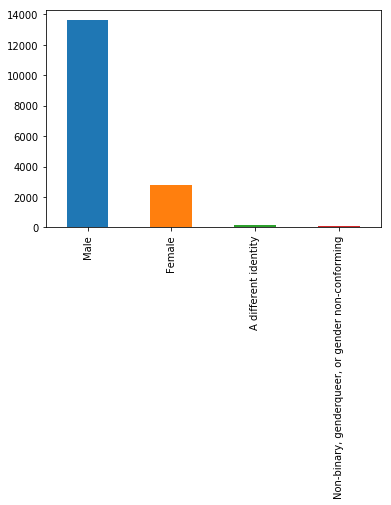

In [8]:
multi.GenderSelect.value_counts().plot(kind='bar');#, legend=True);

#### Държава:

In [9]:
print(multi.Country.value_counts())

United States     4197
India             2704
Other             1023
Russia             578
United Kingdom     535
                  ... 
Kenya               59
Belarus             54
Czech Republic      53
Norway              53
Chile               51
Name: Country, Length: 52, dtype: int64


Целта на курса е догодина България да е в статистиката 😆

#### Възраст:

In [10]:
print(multi.Age.value_counts());

25.0    969
24.0    898
26.0    886
27.0    842
23.0    839
       ... 
83.0      1
94.0      1
10.0      1
82.0      1
9.0       1
Name: Age, Length: 84, dtype: int64


Интересно - точно десет от анкетираните са на 100 години 👴. Да видим и графично.

ValueError: cannot convert float NaN to integer

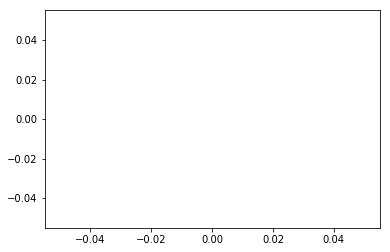

In [11]:
sns.distplot(multi.Age);

Разбира се че ще има NaNs. Втори опит:

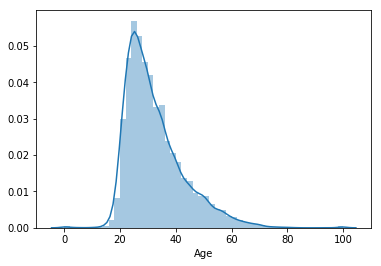

In [12]:
sns.distplot(multi.Age[multi.Age.notnull()]);

#### Заплати:

TypeError: unsupported operand type(s) for /: 'str' and 'int'

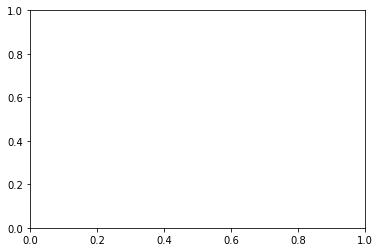

In [13]:
sns.distplot(multi.CompensationAmount[multi.CompensationAmount.notnull()]);

Чудесно, сега и типа ще оправяме. След малко опити установих, че това е някаква легендарна структура, която миксира `float` за NaNs и `String` за числовите стойности:

In [14]:
multi[:20].CompensationAmount.apply(lambda x: print(x, type(x)));

nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
250,000 <class 'str'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
80000 <class 'str'>
1200000 <class 'str'>
nan <class 'float'>
95,000 <class 'str'>
nan <class 'float'>
nan <class 'float'>
1100000 <class 'str'>
120,000 <class 'str'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>


Следващия ред по принцип работи, но дава "FUTURE WARNING" 😕! (Отрязването [:0] е за да демонстрирам Warning-a без да печатам данните.)

In [15]:
multi[:0].CompensationAmount.convert_objects(convert_numeric=True)

/home/bob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


Series([], Name: CompensationAmount, dtype: object)

Ще пробвам да сменя типа по друг начин:

In [16]:
pd.to_numeric(multi.CompensationAmount, errors='raise')

ValueError: Unable to parse string "250,000" at position 3

Освен запетайка за хилядите, имаме още един чупещ символ - тире. Преди да презапишем в дата фрейма ще направим проверка.

In [17]:
temp = pd.to_numeric(multi.CompensationAmount.str.replace(',', '').str.replace('-', ''), errors='raise')
pd.DataFrame(data={'original': multi.CompensationAmount.iloc[10364:10374], 'new': temp[10364:10374]})

,new,original
10364,NaN,NaN
10365,NaN,-
10366,NaN,NaN
10367,NaN,NaN
10368,NaN,NaN
10369,NaN,NaN
10370,12000000.0,"12,000,000"
10371,NaN,NaN
10372,130000.0,130000
10373,90000.0,90000


Сега да омажем DataFrame-a

In [18]:
multi.CompensationAmount = pd.to_numeric(multi.CompensationAmount.str.replace(',', '').str.replace('-', ''), errors='raise')

Графика

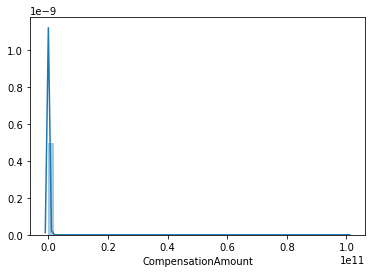

In [19]:
sns.distplot(multi.CompensationAmount[multi.CompensationAmount.notnull()]);

Я, някакви високи стойности изкривяват графиката.

In [20]:
compensation = pd.DataFrame(multi.CompensationAmount[multi.CompensationAmount.notnull()])
print(compensation.sort_values('CompensationAmount').head(5))
print(compensation.sort_values('CompensationAmount').tail(5))

       CompensationAmount
10525                 0.0
11978                 0.0
5960                  0.0
1693                  0.0
6420                  0.0
       CompensationAmount
9747         7.500000e+08
13418        8.000000e+08
5761         1.194000e+09
804          1.000000e+11
5458         1.000000e+11


Ще вземем логаритъм, за целта ще трябва да разкараме нулевите стойности:

In [21]:
print(compensation.iloc[compensation.CompensationAmount.nonzero()])
log_compensation = compensation.iloc[compensation.CompensationAmount.nonzero()]

       CompensationAmount
3                250000.0
8                 80000.0
9               1200000.0
11                95000.0
14              1100000.0
...                   ...
16525            200000.0
16532             82000.0
16577             75000.0
16673             90000.0
16700             10000.0

[5162 rows x 1 columns]


Графика - "Преди и сега":

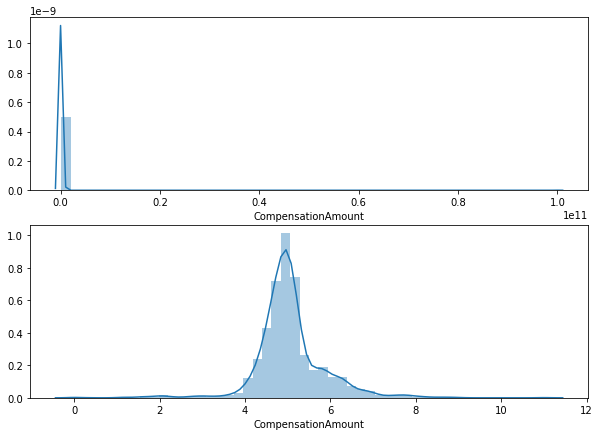

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 7), sharey=False)
sns.distplot(multi.CompensationAmount[multi.CompensationAmount.notnull()], ax=ax1)
sns.distplot(pd.np.log10(log_compensation.CompensationAmount), ax=ax2);

Страхотно, ама е грешно, защото не сме използвали валутните курсове.

In [23]:
rates = pd.read_csv('data/conversionRates.csv', encoding='latin_1', low_memory=False)
rates[:10]

,Unnamed: 0,originCountry,exchangeRate
0,1,USD,1.000000
1,2,EUR,1.195826
2,3,INR,0.015620
3,4,GBP,1.324188
4,5,BRL,0.321350
5,6,RUB,0.017402
6,7,CAD,0.823688
7,8,AUD,0.802310
8,9,JPY,0.009108
9,10,CNY,0.153000


In [24]:
print('Има ли дупликати в originCountry?', all(rates.originCountry.duplicated()))

Има ли дупликати в originCountry? False


Тогава да сменим индекса:

In [25]:
rates = rates.set_index('originCountry')
print(rates.columns)

Index(['Unnamed: 0', 'exchangeRate'], dtype='object')


Да разкараме излишната колона:

In [26]:
rates = rates.drop('Unnamed: 0', axis=1)
rates[:10]

,exchangeRate
originCountry,
USD,1.000000
EUR,1.195826
INR,0.015620
GBP,1.324188
BRL,0.321350
RUB,0.017402
CAD,0.823688
AUD,0.802310
JPY,0.009108


In [27]:
pd.DataFrame(data={'compensation': multi.CompensationAmount, 'code': multi.CompensationCurrency})[:10]

,code,compensation
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,USD,250000.0
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,AUD,80000.0
9,RUB,1200000.0


Имаме както стйности за които липсва валута, така и валута за която липсва стойност. Ще сложим USD за липсващата валута, а тъй като ще работим само с не-NaN стойности, другите няма да е необходимо да ги променяме.

In [28]:
multi.CompensationCurrency = multi.CompensationCurrency.fillna('USD');
pd.DataFrame(data={'compensation': multi.CompensationAmount, 'code': multi.CompensationCurrency}) [:10]

,code,compensation
0,USD,NaN
1,USD,NaN
2,USD,NaN
3,USD,250000.0
4,USD,NaN
5,USD,NaN
6,USD,NaN
7,USD,NaN
8,AUD,80000.0
9,RUB,1200000.0


Да калкулираме компенсацията в USD:

In [29]:
multi['compensation'] = multi.apply(lambda row: row['CompensationAmount'] * rates.loc[row['CompensationCurrency']], axis=1)

KeyError: ('the label [SPL] is not in the [index]', 'occurred at index 12623')

Разбира се че ще има нечия заплата дадена в [Себоргийско](https://bg.wikipedia.org/wiki/%D0%A1%D0%B5%D0%B1%D0%BE%D1%80%D0%B3%D0%B0) Луиджино, а други изненади има ли?

In [30]:
set(multi.CompensationCurrency.unique()) - set(rates.index)

{'SPL'}

Просто ще го добавим - проверих курса USD/SPL = 6

In [31]:
rates.loc['SPL'] = 6.0
set(multi.CompensationCurrency.unique()) - set(rates.index)

set()

In [32]:
multi['compensation'] = multi.apply(lambda row: row['CompensationAmount'] * rates.loc[row['CompensationCurrency']], axis=1)
multi.columns

Index(['GenderSelect', 'Country', 'Age', 'EmploymentStatus', 'StudentStatus',
       'LearningDataScience', 'CodeWriter', 'CareerSwitcher',
       'CurrentJobTitleSelect', 'TitleFit',
       ...
       'JobFactorDepartment', 'JobFactorTitle', 'JobFactorCompanyFunding',
       'JobFactorImpact', 'JobFactorRemote', 'JobFactorIndustry',
       'JobFactorLeaderReputation', 'JobFactorDiversity',
       'JobFactorPublishingOpportunity', 'compensation'],
      dtype='object', length=229)

In [33]:
logable = multi.compensation[multi.compensation.notnull()]
logable = logable[logable != 0]
logable[:10]

3     250000.000
8      64184.800
9      20882.400
11      1483.900
14     36634.400
15    120000.000
21     20000.000
22    100000.000
23       916.400
25     10858.848
Name: compensation, dtype: float64

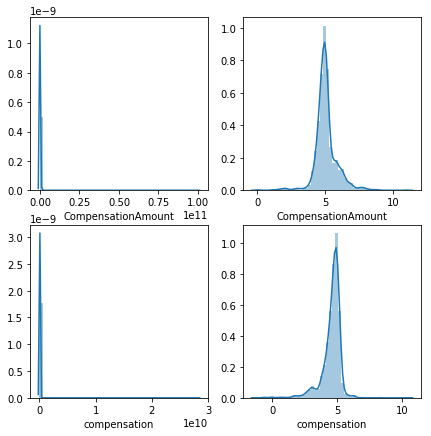

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7), sharey=False)
sns.distplot(compensation.CompensationAmount, ax=axes[0, 0])
sns.distplot(pd.np.log10(log_compensation.CompensationAmount), ax=axes[0, 1])
sns.distplot(multi.compensation[multi.compensation.notnull()], ax=axes[1, 0])
sns.distplot(pd.np.log10(logable), ax=axes[1, 1])

Балкан разлика.

#### Платформа за обучение:

In [35]:
pd.options.display.max_rows = 20
multi.LearningPlatformSelect

0        College/University,Conferences,Podcasts,Trade ...
1                                                   Kaggle
2        Arxiv,College/University,Kaggle,Online courses...
3        Blogs,College/University,Conferences,Friends n...
4                        Arxiv,Conferences,Kaggle,Textbook
5        Kaggle,Online courses,Stack Overflow Q&A,Textbook
6            Arxiv,Blogs,Kaggle,Personal Projects,Textbook
7        College/University,Kaggle,Online courses,Stack...
8        Blogs,Company internal community,Conferences,F...
9        Arxiv,Blogs,Conferences,Kaggle,Non-Kaggle onli...
                               ...                        
16706                                                  NaN
16707                                                  NaN
16708                                                  NaN
16709                                                  NaN
16710                                                  NaN
16711                                                  N

In [36]:
pd.options.display.max_rows = 10

Calls към `DataFrame` обекти се форматират в таблици

In [37]:
pd.DataFrame(multi.LearningPlatformSelect.value_counts())

,LearningPlatformSelect
Kaggle,210
Online courses,209
Personal Projects,155
College/University,127
YouTube Videos,127
...,...
"Arxiv,Online courses,Personal Projects,Textbook,YouTube Videos",1
"Blogs,College/University,Conferences,Friends network,Non-Kaggle online communities,Online courses,Textbook,Tutoring/mentoring,YouTube Videos",1
"Company internal community,Conferences,Kaggle,Online courses,Stack Overflow Q&A",1
"College/University,Company internal community,Non-Kaggle online communities,Online courses,Personal Projects,Tutoring/mentoring",1


Ясно е, че отговорите на въпроса са конкатанирани в стринг и ще трябва да се разбият на отделни колони. За целта първо ще зачистим NaNs.

In [38]:
multi['LearningPlatformSelect'] = multi['LearningPlatformSelect'].fillna('')
multi.LearningPlatformSelect

0        College/University,Conferences,Podcasts,Trade ...
1                                                   Kaggle
2        Arxiv,College/University,Kaggle,Online courses...
3        Blogs,College/University,Conferences,Friends n...
4                        Arxiv,Conferences,Kaggle,Textbook
                               ...                        
16711                                                     
16712    Kaggle,Non-Kaggle online communities,Online co...
16713                                                     
16714                                                     
16715                                                     
Name: LearningPlatformSelect, Length: 16716, dtype: object

Да съберем речник от възможните стойности:

In [39]:
accumulator = set([])
multi.apply(lambda row: accumulator.update(set(row['LearningPlatformSelect'].split(','))), axis=1)
accumulator = accumulator - set([''])
print(len(accumulator), accumulator)

19 {'Non-Kaggle online communities', 'Stack Overflow Q&A', 'Blogs', 'YouTube Videos', 'Company internal community', 'Official documentation', 'Podcasts', 'Conferences', 'Textbook', 'Friends network', 'Newsletters', 'Tutoring/mentoring', 'Online courses', 'College/University', 'Arxiv', 'Personal Projects', 'Trade book', 'Other', 'Kaggle'}


Имам чувството, че този фичър няма да е единствения, при който ще е нужно подобно преформатиране. Затова ще си напишем процедура. (вариант с трансформатор ще пробвам в следващия notebook)

In [40]:
def TextToOneHot(source_df, target_feature, categories=None, separator=','):
    # Returns new DataFrame with OneHotEncoding of Categories
    #    extracted from the text of the target feature.
    
    # backup the data
    df = source_df.copy()
    
    # clear NaNs
    df[target_feature] = df[target_feature].fillna('')
    
    # extract categories, if not provided
    if not categories:
        categories = set([])
        df.apply(lambda row: categories.update(set(row[target_feature].split(separator))), axis=1)
        categories -= set([''])
        
    # loop the categories and map to new features
    pattern = re.compile('[\W]+')
    for category in categories:
        new_feature_name = target_feature + '_' + category.replace(' ', '_')
        new_feature_name = pattern.sub('', new_feature_name)
        df[new_feature_name] = df.apply(lambda row: float(bool(row[target_feature].count(category))), axis=1)
    
    return df


Първо ще тествам с откъс от данните - приготвям dummy_df:

In [41]:
dummy_data = [["Dataset aggregator/platform (i.e. Socrata/Kaggle Datasets/data.world/etc.)","Arxiv,College/University,Kaggle,Online courses,YouTube Videos","Very useful"],
["GitHub","Arxiv,Conferences,Kaggle,Textbook","Very useful"],
["Dataset aggregator/platform (i.e. Socrata/Kaggle Datasets/data.world/etc.)","Arxiv,Blogs,Kaggle,Personal Projects,Textbook","Somewhat useful"],
["I collect my own data (e.g. web-scraping)","Arxiv,Blogs,Conferences,Kaggle,Non-Kaggle online communities,Official documentation,Online courses,Personal Projects,Podcasts,Stack Overflow Q&A,Textbook,YouTube Videos","Somewhat useful"],
["Dataset aggregator/platform (i.e. Socrata/Kaggle Datasets/data.world/etc.)","Arxiv,College/University,Kaggle,Stack Overflow Q&A,Textbook,Tutoring/mentoring","Somewhat useful"],
["Dataset aggregator/platform (i.e. Socrata/Kaggle Datasets/data.world/etc.)","Arxiv,Blogs,Company internal community,Conferences,Kaggle,Non-Kaggle online communities,Personal Projects,Podcasts,Stack Overflow Q&A,Textbook,YouTube Videos","Very useful"],
["Google Search","Arxiv,Blogs,College/University,Company internal community,Conferences,Kaggle,Newsletters,Non-Kaggle online communities,Official documentation,Online courses,Personal Projects,Podcasts,Stack Overflow Q&A,Textbook,Trade book,Tutoring/mentoring,YouTube Videos","Very useful"],
["I collect my own data (e.g. web-scraping)","Arxiv,Blogs,Kaggle,Online courses,Personal Projects,Stack Overflow Q&A,YouTube Videos","Very useful"],
["University/Non-profit research group websites","Arxiv,Blogs,College/University,Conferences,Kaggle,Non-Kaggle online communities,Official documentation,Stack Overflow Q&A","Very useful"],
["Dataset aggregator/platform (i.e. Socrata/Kaggle Datasets/data.world/etc.)","Arxiv,Blogs,College/University,Kaggle,Newsletters,Stack Overflow Q&A,YouTube Videos","Very useful"],
["Dataset aggregator/platform (i.e. Socrata/Kaggle Datasets/data.world/etc.)","Arxiv,Blogs,College/University,Company internal community,Friends network,Kaggle,Non-Kaggle online communities,Official documentation,Online courses,Personal Projects,Stack Overflow Q&A,Textbook,YouTube Videos","Somewhat useful"],
["University/Non-profit research group websites","Arxiv,Kaggle,Official documentation,Online courses,Stack Overflow Q&A,YouTube Videos","Somewhat useful"],
["Dataset aggregator/platform (i.e. Socrata/Kaggle Datasets/data.world/etc.)","Arxiv,Blogs,Conferences,Kaggle,Non-Kaggle online communities","Very useful"]]

dummy_df = pd.DataFrame(data=dummy_data)
dummy_df.columns = ['PersonalProjectsChallengeFreeForm','LearningPlatformSelect','LearningPlatformCommunityFreeForm']

# adding NaN to make it more realistic
dummy_df['LearningPlatformSelect'][8] = None
dummy_df

,PersonalProjectsChallengeFreeForm,LearningPlatformSelect,LearningPlatformCommunityFreeForm
0,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,College/University,Kaggle,Online courses...",Very useful
1,GitHub,"Arxiv,Conferences,Kaggle,Textbook",Very useful
2,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,Blogs,Kaggle,Personal Projects,Textbook",Somewhat useful
3,I collect my own data (e.g. web-scraping),"Arxiv,Blogs,Conferences,Kaggle,Non-Kaggle onli...",Somewhat useful
4,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,College/University,Kaggle,Stack Overflow...",Somewhat useful
...,...,...,...
8,University/Non-profit research group websites,None,Very useful
9,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,Blogs,College/University,Kaggle,Newslett...",Very useful
10,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,Blogs,College/University,Company interna...",Somewhat useful
11,University/Non-profit research group websites,"Arxiv,Kaggle,Official documentation,Online cou...",Somewhat useful


Прилагаме процедурата за енкодинг:

In [42]:
new_df = TextToOneHot(dummy_df, 'LearningPlatformSelect')
new_df

,PersonalProjectsChallengeFreeForm,LearningPlatformSelect,LearningPlatformCommunityFreeForm,LearningPlatformSelect_NonKaggle_online_communities,LearningPlatformSelect_Stack_Overflow_QA,LearningPlatformSelect_Blogs,LearningPlatformSelect_YouTube_Videos,LearningPlatformSelect_Company_internal_community,LearningPlatformSelect_Official_documentation,LearningPlatformSelect_Podcasts,...,LearningPlatformSelect_Textbook,LearningPlatformSelect_Newsletters,LearningPlatformSelect_Friends_network,LearningPlatformSelect_Tutoringmentoring,LearningPlatformSelect_Online_courses,LearningPlatformSelect_CollegeUniversity,LearningPlatformSelect_Arxiv,LearningPlatformSelect_Personal_Projects,LearningPlatformSelect_Trade_book,LearningPlatformSelect_Kaggle
0,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,College/University,Kaggle,Online courses...",Very useful,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
1,GitHub,"Arxiv,Conferences,Kaggle,Textbook",Very useful,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,Blogs,Kaggle,Personal Projects,Textbook",Somewhat useful,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
3,I collect my own data (e.g. web-scraping),"Arxiv,Blogs,Conferences,Kaggle,Non-Kaggle onli...",Somewhat useful,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
4,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,College/University,Kaggle,Stack Overflow...",Somewhat useful,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,University/Non-profit research group websites,,Very useful,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,Blogs,College/University,Kaggle,Newslett...",Very useful,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
10,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,Blogs,College/University,Company interna...",Somewhat useful,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
11,University/Non-profit research group websites,"Arxiv,Kaggle,Official documentation,Online cou...",Somewhat useful,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


Проверяваме резултата:
 * стойността в новия DataFrame
 * стойността в оригиналния, dummy DataFrame
 * `str.count('LearningPlatformSelect')` върху стойността от dummy DataFrame

In [43]:
pd.DataFrame(data = {'old': dummy_df['LearningPlatformSelect'],\
                     'NonKaggle_online_communities': new_df.LearningPlatformSelect_NonKaggle_online_communities,\
                     'count `Non-Kaggle`': dummy_df['LearningPlatformSelect'].apply(lambda row: '' if not row else row.count('Non-Kaggle online communities'))
                    })

,NonKaggle_online_communities,count `Non-Kaggle`,old
0,0.0,0,"Arxiv,College/University,Kaggle,Online courses..."
1,0.0,0,"Arxiv,Conferences,Kaggle,Textbook"
2,0.0,0,"Arxiv,Blogs,Kaggle,Personal Projects,Textbook"
3,1.0,1,"Arxiv,Blogs,Conferences,Kaggle,Non-Kaggle onli..."
4,0.0,0,"Arxiv,College/University,Kaggle,Stack Overflow..."
...,...,...,...
8,0.0,,None
9,0.0,0,"Arxiv,Blogs,College/University,Kaggle,Newslett..."
10,1.0,1,"Arxiv,Blogs,College/University,Company interna..."
11,0.0,0,"Arxiv,Kaggle,Official documentation,Online cou..."


To be continued...